[Dataset Link - Construction Site Safety (CSS)](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`

## Setting up the environment

### List out GPUs available and in use

In [15]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9adc4216-517e-a4f4-a1e7-aa5d0051b3d5)
GPU 1: Tesla T4 (UUID: GPU-249bf3dd-9489-c340-a807-bb848d01ddad)


### Necessary Imports and Dependencies

In [16]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 194 ms, sys: 52.7 ms, total: 246 ms
Wall time: 13.3 s


In [17]:
import ultralytics

import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

### Wandb is a tool to get insights during development stage, it is resource intensive and not required for the current use case

In [18]:
! wandb disabled

W&B disabled.


### Creating a standard config class - allows for easy changing and tuning of hyperparameters

In [19]:
class CONFIG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 1789

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'Multiclass_CSS_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

### YAML Config file for the YOLO model - for training, testing and validation paths and class label information

In [20]:
model_config = {
    'train': os.path.join(CONFIG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CONFIG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CONFIG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CONFIG.NUM_CLASSES_TO_TRAIN,
    'names': CONFIG.CLASSES
    }

with open(os.path.join(CONFIG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(model_config, file)

In [21]:
!cat data.yaml

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid


## Dataset Visualization and Information

### Visualize one image

In [22]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



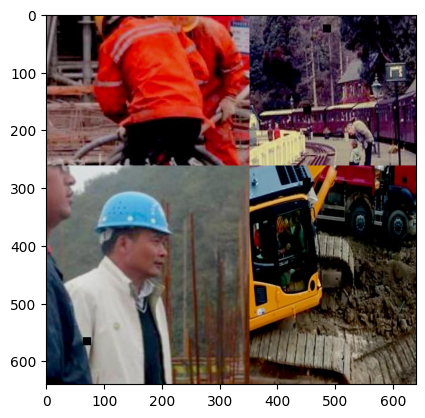

In [23]:
example_image_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

### Visualize many images

In [24]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CONFIG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

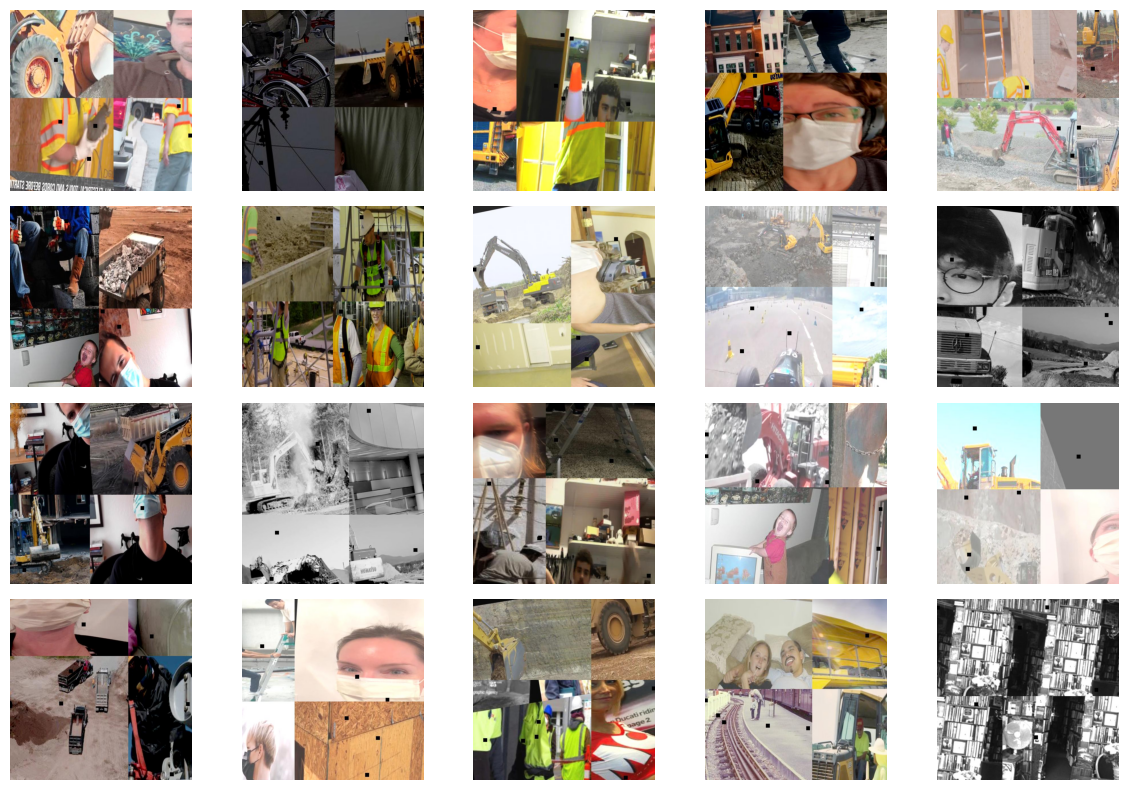

In [25]:
folder_path = CONFIG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CONFIG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

### Image properties

In [26]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [27]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [28]:
%%time
class_idx = {str(i): CONFIG.CLASSES[i] for i in range(CONFIG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CONFIG.CLASSES[i]: 0 for i in range(CONFIG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CONFIG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 157 ms, sys: 100 ms, total: 257 ms
Wall time: 1.31 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


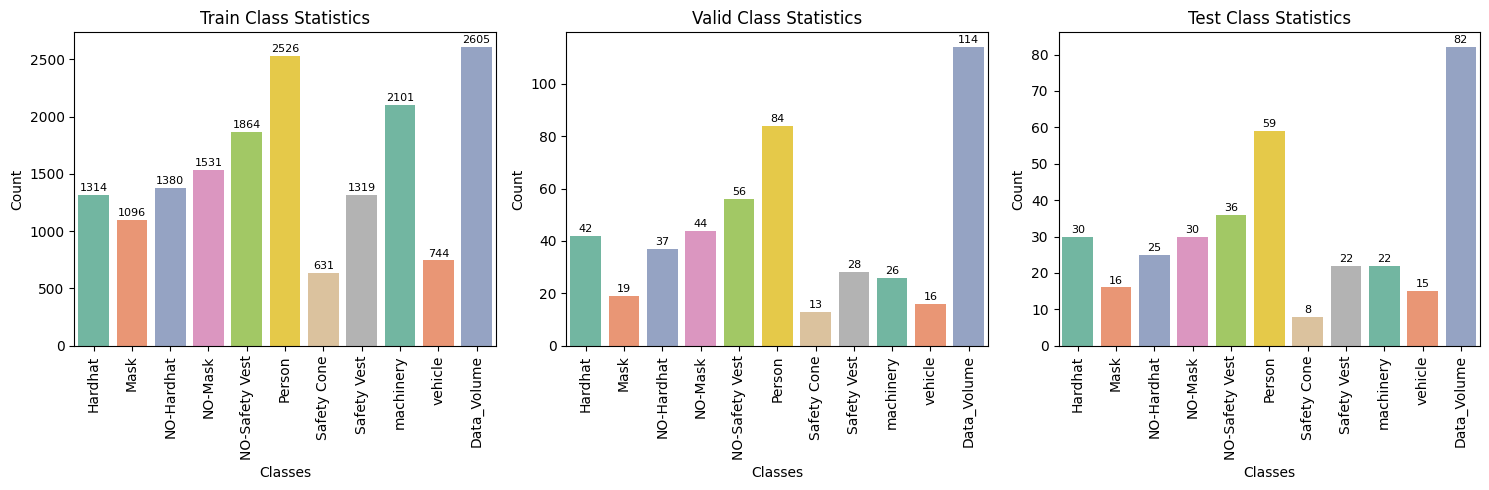

In [29]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [30]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CONFIG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)




KeyboardInterrupt: 

## Training the model

In [31]:
### Load pre-trained YOLO model
model = YOLO(CONFIG.BASE_MODEL_WEIGHTS)

In [35]:
%%time

### train
model.train(
    data = os.path.join(CONFIG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = 20,
    batch = CONFIG.BATCH_SIZE,
    optimizer = CONFIG.OPTIMIZER,
    lr0 = CONFIG.LR,
    lrf = CONFIG.LR_FACTOR,
    weight_decay = CONFIG.WEIGHT_DECAY,
    dropout = CONFIG.DROPOUT,
    fraction = CONFIG.FRACTION,
    patience = CONFIG.PATIENCE,
    profile = CONFIG.PROFILE,
    label_smoothing = CONFIG.LABEL_SMOOTHING,

    name = f'{CONFIG.BASE_MODEL}_{CONFIG.EXP_NAME}',
    seed = CONFIG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
)

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=./data.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_Multiclass_CSS_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=1789, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 74.3MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:05<00:00, 451.68it/s]

train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 335.79it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8x_Multiclass_CSS_50_epochs
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      13.5G       1.23      1.734      1.454        362        640: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all        114        697      0.568      0.497      0.481      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      14.4G       1.25       1.52      1.468        209        640: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.533      0.496      0.502      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      14.4G      1.243      1.502      1.463        205        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        114        697      0.569      0.479      0.469      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      14.3G      1.209      1.426      1.436        241        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.739      0.492      0.549       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      14.3G      1.164      1.309      1.406        209        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.685      0.527      0.587      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      14.3G      1.122      1.218      1.369        196        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.739      0.576      0.637      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      14.4G      1.087      1.133      1.338        244        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697       0.78      0.623      0.665      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      14.4G      1.051      1.076      1.319        282        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        114        697      0.789      0.639      0.693      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      14.4G      1.013     0.9945      1.285        306        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.793      0.651      0.712      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      14.4G     0.9887     0.9504      1.266        330        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.842      0.638      0.723      0.409


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      14.4G      1.019     0.8669      1.291        141        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.795      0.687      0.741      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      14.3G     0.9991     0.8223      1.273        149        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697       0.81      0.662      0.734      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      14.4G     0.9633     0.7719      1.243        253        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.859      0.679      0.761      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      14.3G      0.934     0.7308      1.225        158        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.834      0.714      0.776      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      14.3G     0.8916     0.6801      1.193        136        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697       0.87      0.712      0.794      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      14.3G      0.868     0.6397      1.187        135        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.864       0.74      0.803      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      14.4G     0.8332     0.5996      1.156        234        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.934      0.704      0.812      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      14.3G     0.8032     0.5649      1.133        127        640: 100%|██████████| 163/163 [03:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.888      0.713      0.811      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      14.3G      0.773     0.5361      1.118        165        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        114        697      0.898      0.748      0.827      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      14.3G     0.7394      0.502      1.094        127        640: 100%|██████████| 163/163 [03:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        114        697      0.911      0.748      0.823      0.524



20 epochs completed in 1.112 hours.
Optimizer stripped from runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.pt, 136.7MB

Validating runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


                   all        114        697      0.911      0.748      0.823      0.525
Speed: 2.3ms preprocess, 27.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/yolov8x_Multiclass_CSS_50_epochs
CPU times: user 1h 1min 38s, sys: 5min 40s, total: 1h 7min 18s
Wall time: 1h 7min 40s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f02f65125f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

## Visualizing Results and exporting model

In [38]:
# Export the model
model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (130.4 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 4.3s, saved as 'runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.onnx' (260.1 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 59.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━

'runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best_openvino_model'

In [36]:
results_paths = [
    i for i in
    glob.glob(f'{CONFIG.OUTPUT_DIR}runs/detect/{CONFIG.BASE_MODEL}_{CONFIG.EXP_NAME}/*.png') +
    glob.glob(f'{CONFIG.OUTPUT_DIR}runs/detect/{CONFIG.BASE_MODEL}_{CONFIG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8x_Multiclass_CSS_50_epochs/results.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/confusion_matrix.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/PR_curve.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/F1_curve.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/P_curve.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/R_curve.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels.jpg',
 './runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels_correlogram.jpg']

./runs/detect/yolov8x_Multiclass_CSS_50_epochs/F1_curve.png


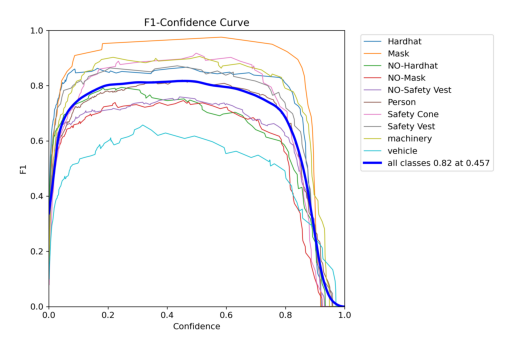



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/PR_curve.png


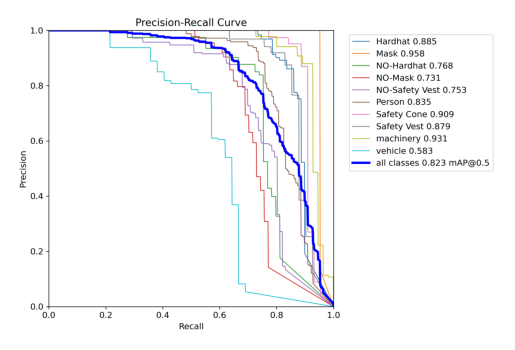



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/P_curve.png


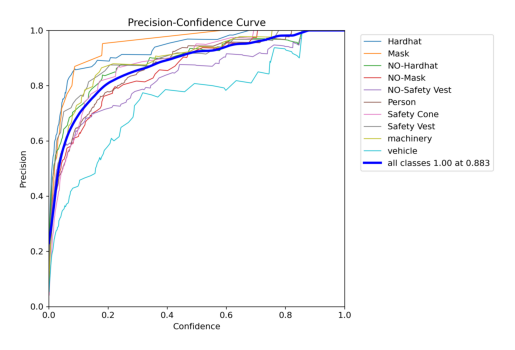



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/R_curve.png


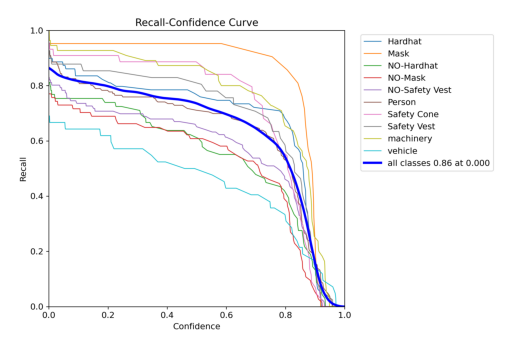



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/confusion_matrix.png


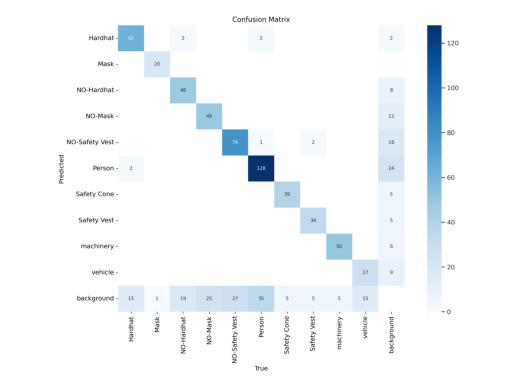



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/confusion_matrix_normalized.png


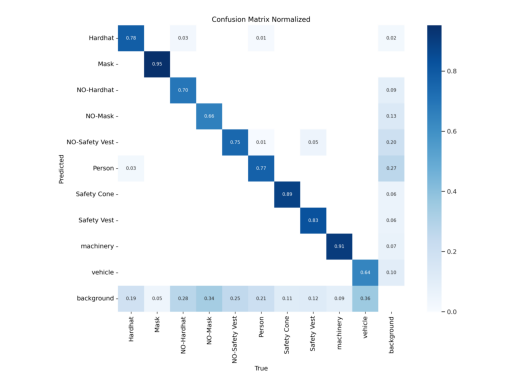



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels.jpg


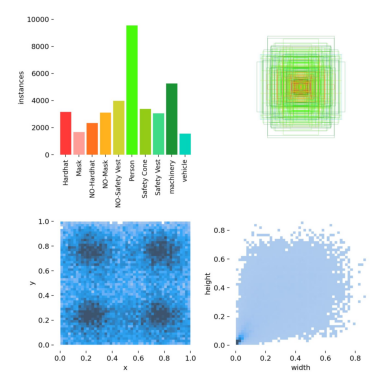



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels_correlogram.jpg


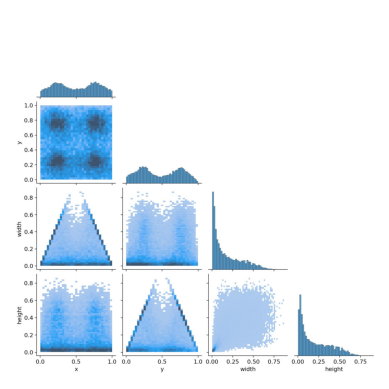



./runs/detect/yolov8x_Multiclass_CSS_50_epochs/results.png


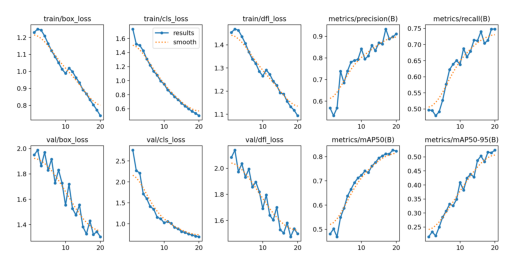

In [37]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

## Loss Metrics visualization

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [39]:
df = pd.read_csv(f'{CONFIG.OUTPUT_DIR}runs/detect/{CONFIG.BASE_MODEL}_{CONFIG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CONFIG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.23000,1.73420,1.4540,0.56848,0.49695,0.48062,0.21545,1.9500,2.75770,2.0838,0.000237,0.000237,0.000237
1,2,1.24960,1.51960,1.4684,0.53290,0.49570,0.50195,0.23318,1.9881,2.27010,2.1390,0.000451,0.000451,0.000451
2,3,1.24300,1.50190,1.4630,0.56852,0.47927,0.46915,0.21866,1.8634,2.20970,1.9730,0.000642,0.000642,0.000642
3,4,1.20900,1.42570,1.4361,0.73871,0.49154,0.54945,0.24962,1.9698,1.71160,2.0351,0.000608,0.000608,0.000608
4,5,1.16390,1.30910,1.4059,0.68484,0.52722,0.58745,0.28509,1.8299,1.59890,1.9314,0.000608,0.000608,0.000608
5,6,1.12170,1.21820,1.3693,0.73941,0.57646,0.63747,0.30671,1.9165,1.41040,1.9939,0.000573,0.000573,0.000573
6,7,1.08690,1.13350,1.3384,0.78049,0.62260,0.66523,0.33192,1.7281,1.34980,1.8556,0.000537,0.000537,0.000537
7,8,1.05080,1.07650,1.3194,0.78891,0.63911,0.69272,0.32602,1.8315,1.15580,1.8946,0.000502,0.000502,0.000502
8,9,1.01270,0.99446,1.2852,0.79333,0.65063,0.71228,0.34884,1.7278,1.12150,1.8203,0.000467,0.000467,0.000467
9,10,0.98874,0.95037,1.2656,0.84232,0.63813,0.72318,0.40899,1.5541,1.02370,1.6905,0.000431,0.000431,0.000431


In [40]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.73936 , on epoch:  20 


Best Validation Box loss:  1.3044 , on epoch:  20 


Best Training Cls loss:  0.50201 , on epoch:  20 


Best Validation Cls loss:  0.69101 , on epoch:  20 


Best Training DFL loss:  1.094 , on epoch:  20 


Best Validation DFL loss:  1.4756 , on epoch:  20 



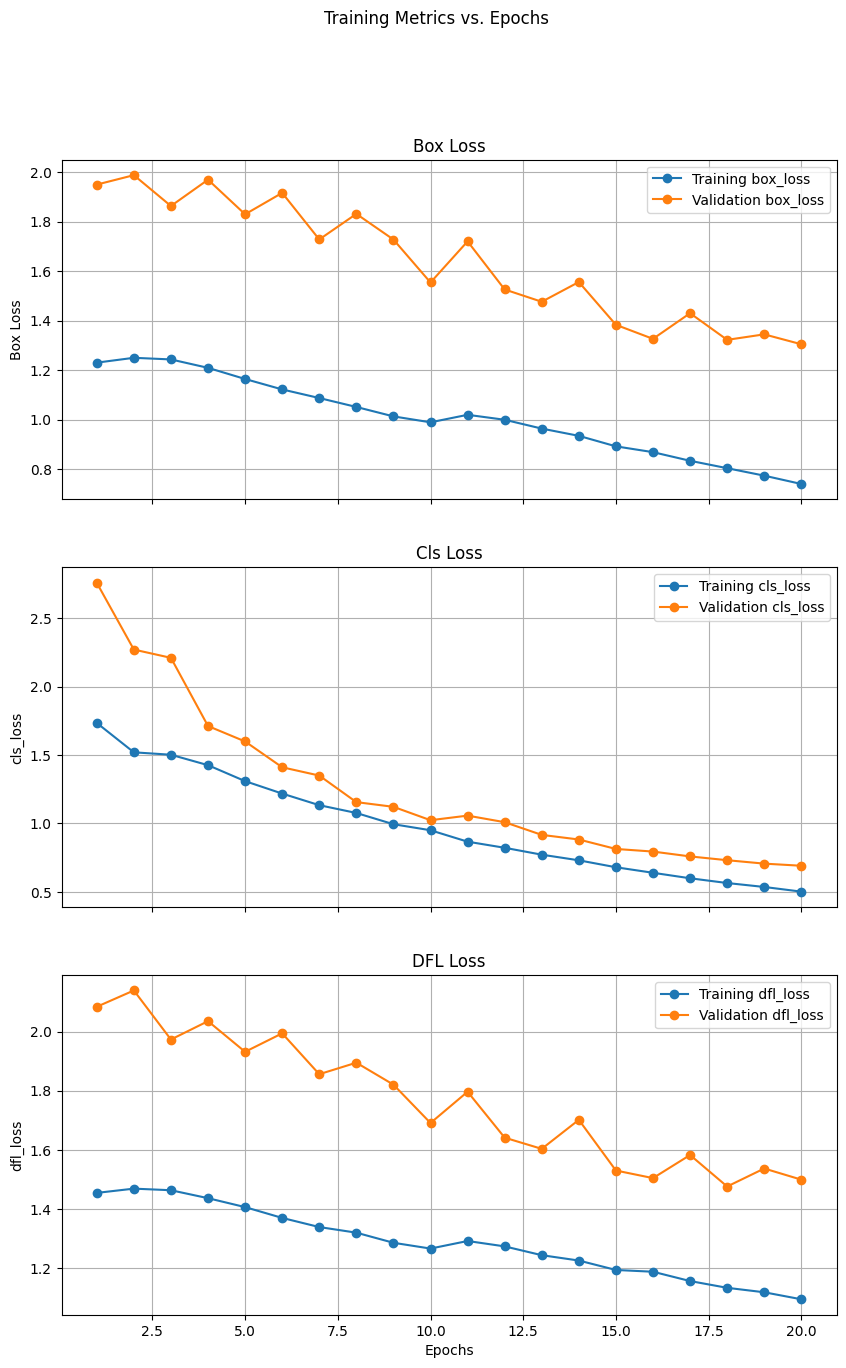

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

## Experimentation Results

In [ ]:
model.train(
    data = os.path.join(CONFIG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = 20,
    batch = CONFIG.BATCH_SIZE,
    optimizer = CONFIG.OPTIMIZER,
    lr0 = CONFIG.LR,
    lrf = CONFIG.LR_FACTOR,
    weight_decay = CONFIG.WEIGHT_DECAY,
    dropout = CONFIG.DROPOUT,
    fraction = CONFIG.FRACTION,
    patience = CONFIG.PATIENCE,
    profile = CONFIG.PROFILE,
    label_smoothing = CONFIG.LABEL_SMOOTHING,

    name = f'{CONFIG.BASE_MODEL}_{CONFIG.EXP_NAME}',
    seed = CONFIG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
)

### Results:
    Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
    Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                   all        114        697      0.911      0.748      0.823      0.525
    Speed: 2.3ms preprocess, 27.0ms inference, 0.0ms loss, 1.5ms postprocess per image
    Results saved to runs/detect/yolov8x_Multiclass_CSS_50_epochs
    CPU times: user 1h 1min 38s, sys: 5min 40s, total: 1h 7min 18s
    Wall time: 1h 7min 40s

    Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
    engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=./data.yaml, epochs=20, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_Multiclass_CSS_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=1789, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4, nms=False, lr0=0.001, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, dfl=1.5, pose=12.0, kobj=1.0, label_smoothing=0.0, nbs=64, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0, auto_augment=randaugment, erasing=0.4, crop_fraction=1.0, cfg=None, tracker=botsort.yaml, save_dir=runs/detect/yolov8x_Multiclass_CSS_50_epochs
    Downloading https://ultralytics.com/assets/Arial.ttf to '/root/.config/Ultralytics/Arial.ttf'...
    100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]
    Overriding model.yaml nc=80 with nc=10

                       from  n    params  module                                       arguments                     
      0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
      1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
      2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
      3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
      4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
      5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
      6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
      7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
      8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
      9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
     10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
     11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
     12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
     13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
     14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
     15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960, 320, 3]                 
     16                  -1  1    922240  ultralytics.nn.modules.conv.Conv             [320, 320, 3, 2]              
     17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
     18                  -1  3   7174400  ultralytics.nn.modules.block.C2f             [960, 640, 3]                 
     19                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
     20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
     21                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
     22        [15, 18, 21]  1   8727598  ultralytics.nn.modules.head.Detect           [10, [320, 640, 640]]         
    Model summary: 365 layers, 68162238 parameters, 68162222 gradients, 258.2 GFLOPs

    Transferred 589/595 items from pretrained weights
    TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8x_Multiclass_CSS_50_epochs', view at http://localhost:6006/
    Freezing layer 'model.22.dfl.conv.weight'
    AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
    Downloading https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n.pt to 'yolov8n.pt'...
    100%|██████████| 6.23M/6.23M [00:00<00:00, 74.3MB/s]
    AMP: checks passed ✅
    WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
    train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:05<00:00, 451.68it/s]
    train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
    train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed

    train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
    albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
    val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 335.79it/s]
    val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.

    Plotting labels to runs/detect/yolov8x_Multiclass_CSS_50_epochs/labels.jpg... 
    optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
    optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
    TensorBoard: model graph visualization added ✅
    Image sizes 640 train, 640 val
    Using 4 dataloader workers
    Logging results to runs/detect/yolov8x_Multiclass_CSS_50_epochs
    Starting training for 20 epochs...

          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           1/20      13.5G       1.23      1.734      1.454        362        640: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
                       all        114        697      0.568      0.497      0.481      0.215


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           2/20      14.4G       1.25       1.52      1.468        209        640: 100%|██████████| 163/163 [03:10<00:00,  1.17s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.533      0.496      0.502      0.233


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           3/20      14.4G      1.243      1.502      1.463        205        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]
                       all        114        697      0.569      0.479      0.469      0.219


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           4/20      14.3G      1.209      1.426      1.436        241        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.739      0.492      0.549       0.25


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           5/20      14.3G      1.164      1.309      1.406        209        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.685      0.527      0.587      0.285


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           6/20      14.3G      1.122      1.218      1.369        196        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.739      0.576      0.637      0.307


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           7/20      14.4G      1.087      1.133      1.338        244        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697       0.78      0.623      0.665      0.332


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           8/20      14.4G      1.051      1.076      1.319        282        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                       all        114        697      0.789      0.639      0.693      0.326


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
           9/20      14.4G      1.013     0.9945      1.285        306        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.793      0.651      0.712      0.349


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          10/20      14.4G     0.9887     0.9504      1.266        330        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.842      0.638      0.723      0.409

    Closing dataloader mosaic
    albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          11/20      14.4G      1.019     0.8669      1.291        141        640: 100%|██████████| 163/163 [03:09<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.795      0.687      0.741      0.382


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          12/20      14.3G     0.9991     0.8223      1.273        149        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697       0.81      0.662      0.734      0.425


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          13/20      14.4G     0.9633     0.7719      1.243        253        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.859      0.679      0.761      0.438


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          14/20      14.3G      0.934     0.7308      1.225        158        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.834      0.714      0.776      0.428


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          15/20      14.3G     0.8916     0.6801      1.193        136        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697       0.87      0.712      0.794      0.487


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          16/20      14.3G      0.868     0.6397      1.187        135        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.864       0.74      0.803      0.503


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          17/20      14.4G     0.8332     0.5996      1.156        234        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.934      0.704      0.812      0.483


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          18/20      14.3G     0.8032     0.5649      1.133        127        640: 100%|██████████| 163/163 [03:08<00:00,  1.15s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.888      0.713      0.811      0.517


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          19/20      14.3G      0.773     0.5361      1.118        165        640: 100%|██████████| 163/163 [03:08<00:00,  1.16s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                       all        114        697      0.898      0.748      0.827      0.515


          Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
          20/20      14.3G     0.7394      0.502      1.094        127        640: 100%|██████████| 163/163 [03:08<00:00,  1.15s/it]
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                       all        114        697      0.911      0.748      0.823      0.524


    20 epochs completed in 1.112 hours.
    Optimizer stripped from runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/last.pt, 136.7MB
    Optimizer stripped from runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.pt, 136.7MB

    Validating runs/detect/yolov8x_Multiclass_CSS_50_epochs/weights/best.pt...
    Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
    Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs
                     Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                       all        114        697      0.911      0.748      0.823      0.525
    Speed: 2.3ms preprocess, 27.0ms inference, 0.0ms loss, 1.5ms postprocess per image
    Results saved to runs/detect/yolov8x_Multiclass_CSS_50_epochs
    CPU times: user 1h 1min 38s, sys: 5min 40s, total: 1h 7min 18s
    Wall time: 1h 7min 40s
    ultralytics.utils.metrics.DetMetrics object with attributes:

    ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    box: ultralytics.utils.metrics.Metric object
    confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f02f65125f0>
    curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
    curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
              0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
              0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
              0.072072,    0.073073,    0.074074,    0.075075,    0.076076,    0.077077,    0.078078,    0.079079,     0.08008,    0.081081,    0.082082,    0.083083,    0.084084,    0.085085,    0.086086,    0.087087,    0.088088,    0.089089,     0.09009,    0.091091,    0.092092,    0.093093,    0.094094,    0.095095,
              0.096096,    0.097097,    0.098098,    0.099099,      0.1001,      0.1011,      0.1021,      0.1031,      0.1041,     0.10511,     0.10611,     0.10711,     0.10811,     0.10911,     0.11011,     0.11111,     0.11211,     0.11311,     0.11411,     0.11512,     0.11612,     0.11712,     0.11812,     0.11912,
               0.12012,     0.12112,     0.12212,     0.12312,     0.12412,     0.12513,     0.12613,     0.12713,     0.12813,     0.12913,     0.13013,     0.13113,     0.13213,     0.13313,     0.13413,     0.13514,     0.13614,     0.13714,     0.13814,     0.13914,     0.14014,     0.14114,     0.14214,     0.14314,
               0.14414,     0.14515,     0.14615,     0.14715,     0.14815,     0.14915,     0.15015,     0.15115,     0.15215,     0.15315,     0.15415,     0.15516,     0.15616,     0.15716,     0.15816,     0.15916,     0.16016,     0.16116,     0.16216,     0.16316,     0.16416,     0.16517,     0.16617,     0.16717,
               0.16817,     0.16917,     0.17017,     0.17117,     0.17217,     0.17317,     0.17417,     0.17518,     0.17618,     0.17718,     0.17818,     0.17918,     0.18018,     0.18118,     0.18218,     0.18318,     0.18418,     0.18519,     0.18619,     0.18719,     0.18819,     0.18919,     0.19019,     0.19119,
               0.19219,     0.19319,     0.19419,      0.1952,      0.1962,      0.1972,      0.1982,      0.1992,      0.2002,      0.2012,      0.2022,      0.2032,      0.2042,     0.20521,     0.20621,     0.20721,     0.20821,     0.20921,     0.21021,     0.21121,     0.21221,     0.21321,     0.21421,     0.21522,
               0.21622,     0.21722,     0.21822,     0.21922,     0.22022,     0.22122,     0.22222,     0.22322,     0.22422,     0.22523,     0.22623,     0.22723,     0.22823,     0.22923,     0.23023,     0.23123,     0.23223,     0.23323,     0.23423,     0.23524,     0.23624,     0.23724,     0.23824,     0.23924,
               0.24024,     0.24124,     0.24224,     0.24324,     0.24424,     0.24525,     0.24625,     0.24725,     0.24825,     0.24925,     0.25025,     0.25125,     0.25225,     0.25325,     0.25425,     0.25526,     0.25626,     0.25726,     0.25826,     0.25926,     0.26026,     0.26126,     0.26226,     0.26326,
               0.26426,     0.26527,     0.26627,     0.26727,     0.26827,     0.26927,     0.27027,     0.27127,     0.27227,     0.27327,     0.27427,     0.27528,     0.27628,     0.27728,     0.27828,     0.27928,     0.28028,     0.28128,     0.28228,     0.28328,     0.28428,     0.28529,     0.28629,     0.28729,
               0.28829,     0.28929,     0.29029,     0.29129,     0.29229,     0.29329,     0.29429,      0.2953,      0.2963,      0.2973,      0.2983,      0.2993,      0.3003,      0.3013,      0.3023,      0.3033,      0.3043,     0.30531,     0.30631,     0.30731,     0.30831,     0.30931,     0.31031,     0.31131,
               0.31231,     0.31331,     0.31431,     0.31532,     0.31632,     0.31732,     0.31832,     0.31932,     0.32032,     0.32132,     0.32232,     0.32332,     0.32432,     0.32533,     0.32633,     0.32733,     0.32833,     0.32933,     0.33033,     0.33133,     0.33233,     0.33333,     0.33433,     0.33534,
               0.33634,     0.33734,     0.33834,     0.33934,     0.34034,     0.34134,     0.34234,     0.34334,     0.34434,     0.34535,     0.34635,     0.34735,     0.34835,     0.34935,     0.35035,     0.35135,     0.35235,     0.35335,     0.35435,     0.35536,     0.35636,     0.35736,     0.35836,     0.35936,
               0.36036,     0.36136,     0.36236,     0.36336,     0.36436,     0.36537,     0.36637,     0.36737,     0.36837,     0.36937,     0.37037,     0.37137,     0.37237,     0.37337,     0.37437,     0.37538,     0.37638,     0.37738,     0.37838,     0.37938,     0.38038,     0.38138,     0.38238,     0.38338,
               0.38438,     0.38539,     0.38639,     0.38739,     0.38839,     0.38939,     0.39039,     0.39139,     0.39239,     0.39339,     0.39439,      0.3954,      0.3964,      0.3974,      0.3984,      0.3994,      0.4004,      0.4014,      0.4024,      0.4034,      0.4044,     0.40541,     0.40641,     0.40741,
               0.40841,     0.40941,     0.41041,     0.41141,     0.41241,     0.41341,     0.41441,     0.41542,     0.41642,     0.41742,     0.41842,     0.41942,     0.42042,     0.42142,     0.42242,     0.42342,     0.42442,     0.42543,     0.42643,     0.42743,     0.42843,     0.42943,     0.43043,     0.43143,
               0.43243,     0.43343,     0.43443,     0.43544,     0.43644,     0.43744,     0.43844,     0.43944,     0.44044,     0.44144,     0.44244,     0.44344,     0.44444,     0.44545,     0.44645,     0.44745,     0.44845,     0.44945,     0.45045,     0.45145,     0.45245,     0.45345,     0.45445,     0.45546,
               0.45646,     0.45746,     0.45846,     0.45946,     0.46046,     0.46146,     0.46246,     0.46346,     0.46446,     0.46547,     0.46647,     0.46747,     0.46847,     0.46947,     0.47047,     0.47147,     0.47247,     0.47347,     0.47447,     0.47548,     0.47648,     0.47748,     0.47848,     0.47948,
               0.48048,     0.48148,     0.48248,     0.48348,     0.48448,     0.48549,     0.48649,     0.48749,     0.48849,     0.48949,     0.49049,     0.49149,     0.49249,     0.49349,     0.49449,      0.4955,      0.4965,      0.4975,      0.4985,      0.4995,      0.5005,      0.5015,      0.5025,      0.5035,
                0.5045,     0.50551,     0.50651,     0.50751,     0.50851,     0.50951,     0.51051,     0.51151,     0.51251,     0.51351,     0.51451,     0.51552,     0.51652,     0.51752,     0.51852,     0.51952,     0.52052,     0.52152,     0.52252,     0.52352,     0.52452,     0.52553,     0.52653,     0.52753,
               0.52853,     0.52953,     0.53053,     0.53153,     0.53253,     0.53353,     0.53453,     0.53554,     0.53654,     0.53754,     0.53854,     0.53954,     0.54054,     0.54154,     0.54254,     0.54354,     0.54454,     0.54555,     0.54655,     0.54755,     0.54855,     0.54955,     0.55055,     0.55155,
               0.55255,     0.55355,     0.55455,     0.55556,     0.55656,     0.55756,     0.55856,     0.55956,     0.56056,     0.56156,     0.56256,     0.56356,     0.56456,     0.56557,     0.56657,     0.56757,     0.56857,     0.56957,     0.57057,     0.57157,     0.57257,     0.57357,     0.57457,     0.57558,
               0.57658,     0.57758,     0.57858,     0.57958,     0.58058,     0.58158,     0.58258,     0.58358,     0.58458,     0.58559,     0.58659,     0.58759,     0.58859,     0.58959,     0.59059,     0.59159,     0.59259,     0.59359,     0.59459,      0.5956,      0.5966,      0.5976,      0.5986,      0.5996,
                0.6006,      0.6016,      0.6026,      0.6036,      0.6046,     0.60561,     0.60661,     0.60761,     0.60861,     0.60961,     0.61061,     0.61161,     0.61261,     0.61361,     0.61461,     0.61562,     0.61662,     0.61762,     0.61862,     0.61962,     0.62062,     0.62162,     0.62262,     0.62362,
               0.62462,     0.62563,     0.62663,     0.62763,     0.62863,     0.62963,     0.63063,     0.63163,     0.63263,     0.63363,     0.63463,     0.63564,     0.63664,     0.63764,     0.63864,     0.63964,     0.64064,     0.64164,     0.64264,     0.64364,     0.64464,     0.64565,     0.64665,     0.64765,
               0.64865,     0.64965,     0.65065,     0.65165,     0.65265,     0.65365,     0.65465,     0.65566,     0.65666,     0.65766,     0.65866,     0.65966,     0.66066,     0.66166,     0.66266,     0.66366,     0.66466,     0.66567,     0.66667,     0.66767,     0.66867,     0.66967,     0.67067,     0.67167,
               0.67267,     0.67367,     0.67467,     0.67568,     0.67668,     0.67768,     0.67868,     0.67968,     0.68068,     0.68168,     0.68268,     0.68368,     0.68468,     0.68569,     0.68669,     0.68769,     0.68869,     0.68969,     0.69069,     0.69169,     0.69269,     0.69369,     0.69469,      0.6957,
                0.6967,      0.6977,      0.6987,      0.6997,      0.7007,      0.7017,      0.7027,      0.7037,      0.7047,     0.70571,     0.70671,     0.70771,     0.70871,     0.70971,     0.71071,     0.71171,     0.71271,     0.71371,     0.71471,     0.71572,     0.71672,     0.71772,     0.71872,     0.71972,
               0.72072,     0.72172,     0.72272,     0.72372,     0.72472,     0.72573,     0.72673,     0.72773,     0.72873,     0.72973,     0.73073,     0.73173,     0.73273,     0.73373,     0.73473,     0.73574,     0.73674,     0.73774,     0.73874,     0.73974,     0.74074,     0.74174,     0.74274,     0.74374,
               0.74474,     0.74575,     0.74675,     0.74775,     0.74875,     0.74975,     0.75075,     0.75175,     0.75275,     0.75375,     0.75475,     0.75576,     0.75676,     0.75776,     0.75876,     0.75976,     0.76076,     0.76176,     0.76276,     0.76376,     0.76476,     0.76577,     0.76677,     0.76777,
               0.76877,     0.76977,     0.77077,     0.77177,     0.77277,     0.77377,     0.77477,     0.77578,     0.77678,     0.77778,     0.77878,     0.77978,     0.78078,     0.78178,     0.78278,     0.78378,     0.78478,     0.78579,     0.78679,     0.78779,     0.78879,     0.78979,     0.79079,     0.79179,
               0.79279,     0.79379,     0.79479,      0.7958,      0.7968,      0.7978,      0.7988,      0.7998,      0.8008,      0.8018,      0.8028,      0.8038,      0.8048,     0.80581,     0.80681,     0.80781,     0.80881,     0.80981,     0.81081,     0.81181,     0.81281,     0.81381,     0.81481,     0.81582,
               0.81682,     0.81782,     0.81882,     0.81982,     0.82082,     0.82182,     0.82282,     0.82382,     0.82482,     0.82583,     0.82683,     0.82783,     0.82883,     0.82983,     0.83083,     0.83183,     0.83283,     0.83383,     0.83483,     0.83584,     0.83684,     0.83784,     0.83884,     0.83984,
               0.84084,     0.84184,     0.84284,     0.84384,     0.84484,     0.84585,     0.84685,     0.84785,     0.84885,     0.84985,     0.85085,     0.85185,     0.85285,     0.85385,     0.85485,     0.85586,     0.85686,     0.85786,     0.85886,     0.85986,     0.86086,     0.86186,     0.86286,     0.86386,
               0.86486,     0.86587,     0.86687,     0.86787,     0.86887,     0.86987,     0.87087,     0.87187,     0.87287,     0.87387,     0.87487,     0.87588,     0.87688,     0.87788,     0.87888,     0.87988,     0.88088,     0.88188,     0.88288,     0.88388,     0.88488,     0.88589,     0.88689,     0.88789,
               0.88889,     0.88989,     0.89089,     0.89189,     0.89289,     0.89389,     0.89489,      0.8959,      0.8969,      0.8979,      0.8989,      0.8999,      0.9009,      0.9019,      0.9029,      0.9039,      0.9049,     0.90591,     0.90691,     0.90791,     0.90891,     0.90991,     0.91091,     0.91191,
               0.91291,     0.91391,     0.91491,     0.91592,     0.91692,     0.91792,     0.91892,     0.91992,     0.92092,     0.92192,     0.92292,     0.92392,     0.92492,     0.92593,     0.92693,     0.92793,     0.92893,     0.92993,     0.93093,     0.93193,     0.93293,     0.93393,     0.93493,     0.93594,
               0.93694,     0.93794,     0.93894,     0.93994,     0.94094,     0.94194,     0.94294,     0.94394,     0.94494,     0.94595,     0.94695,     0.94795,     0.94895,     0.94995,     0.95095,     0.95195,     0.95295,     0.95395,     0.95495,     0.95596,     0.95696,     0.95796,     0.95896,     0.95996,
               0.96096,     0.96196,     0.96296,     0.96396,     0.96496,     0.96597,     0.96697,     0.96797,     0.96897,     0.96997,     0.97097,     0.97197,     0.97297,     0.97397,     0.97497,     0.97598,     0.97698,     0.97798,     0.97898,     0.97998,     0.98098,     0.98198,     0.98298,     0.98398,
               0.98498,     0.98599,     0.98699,     0.98799,     0.98899,     0.98999,     0.99099,     0.99199,     0.99299,     0.99399,     0.99499,       0.996,       0.997,       0.998,       0.999,           1]), array([[          1,           1,           1, ...,   0.0038039,    0.001902,           0],
           [          1,           1,           1, ...,   0.0056814,   0.0028407,           0],
           [          1,           1,           1, ...,   0.0018712,  0.00093562,           0],
           ...,
           [          1,           1,           1, ...,   0.0033757,   0.0016878,           0],
           [          1,           1,           1, ...,     0.10659,     0.10659,           0],
           [          1,           1,           1, ...,  0.00034671,  0.00017336,           0]]), 'Recall', 'Precision'], [array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
              0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
              0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
              0.072072,    0.073073,    0.074074,    0.075075,    0.076076,    0.077077,    0.078078,    0.079079,     0.08008,    0.081081,    0.082082,    0.083083,    0.084084,    0.085085,    0.086086,    0.087087,    0.088088,    0.089089,     0.09009,    0.091091,    0.092092,    0.093093,    0.094094,    0.095095,
              0.096096,    0.097097,    0.098098,    0.099099,      0.1001,      0.1011,      0.1021,      0.1031,      0.1041,     0.10511,     0.10611,     0.10711,     0.10811,     0.10911,     0.11011,     0.11111,     0.11211,     0.11311,     0.11411,     0.11512,     0.11612,     0.11712,     0.11812,     0.11912,
               0.12012,     0.12112,     0.12212,     0.12312,     0.12412,     0.12513,     0.12613,     0.12713,     0.12813,     0.12913,     0.13013,     0.13113,     0.13213,     0.13313,     0.13413,     0.13514,     0.13614,     0.13714,     0.13814,     0.13914,     0.14014,     0.14114,     0.14214,     0.14314,
               0.14414,     0.14515,     0.14615,     0.14715,     0.14815,     0.14915,     0.15015,     0.15115,     0.15215,     0.15315,     0.15415,     0.15516,     0.15616,     0.15716,     0.15816,     0.15916,     0.16016,     0.16116,     0.16216,     0.16316,     0.16416,     0.16517,     0.16617,     0.16717,
               0.16817,     0.16917,     0.17017,     0.17117,     0.17217,     0.17317,     0.17417,     0.17518,     0.17618,     0.17718,     0.17818,     0.17918,     0.18018,     0.18118,     0.18218,     0.18318,     0.18418,     0.18519,     0.18619,     0.18719,     0.18819,     0.18919,     0.19019,     0.19119,
               0.19219,     0.19319,     0.19419,      0.1952,      0.1962,      0.1972,      0.1982,      0.1992,      0.2002,      0.2012,      0.2022,      0.2032,      0.2042,     0.20521,     0.20621,     0.20721,     0.20821,     0.20921,     0.21021,     0.21121,     0.21221,     0.21321,     0.21421,     0.21522,
               0.21622,     0.21722,     0.21822,     0.21922,     0.22022,     0.22122,     0.22222,     0.22322,     0.22422,     0.22523,     0.22623,     0.22723,     0.22823,     0.22923,     0.23023,     0.23123,     0.23223,     0.23323,     0.23423,     0.23524,     0.23624,     0.23724,     0.23824,     0.23924,
               0.24024,     0.24124,     0.24224,     0.24324,     0.24424,     0.24525,     0.24625,     0.24725,     0.24825,     0.24925,     0.25025,     0.25125,     0.25225,     0.25325,     0.25425,     0.25526,     0.25626,     0.25726,     0.25826,     0.25926,     0.26026,     0.26126,     0.26226,     0.26326,
               0.26426,     0.26527,     0.26627,     0.26727,     0.26827,     0.26927,     0.27027,     0.27127,     0.27227,     0.27327,     0.27427,     0.27528,     0.27628,     0.27728,     0.27828,     0.27928,     0.28028,     0.28128,     0.28228,     0.28328,     0.28428,     0.28529,     0.28629,     0.28729,
               0.28829,     0.28929,     0.29029,     0.29129,     0.29229,     0.29329,     0.29429,      0.2953,      0.2963,      0.2973,      0.2983,      0.2993,      0.3003,      0.3013,      0.3023,      0.3033,      0.3043,     0.30531,     0.30631,     0.30731,     0.30831,     0.30931,     0.31031,     0.31131,
               0.31231,     0.31331,     0.31431,     0.31532,     0.31632,     0.31732,     0.31832,     0.31932,     0.32032,     0.32132,     0.32232,     0.32332,     0.32432,     0.32533,     0.32633,     0.32733,     0.32833,     0.32933,     0.33033,     0.33133,     0.33233,     0.33333,     0.33433,     0.33534,
               0.33634,     0.33734,     0.33834,     0.33934,     0.34034,     0.34134,     0.34234,     0.34334,     0.34434,     0.34535,     0.34635,     0.34735,     0.34835,     0.34935,     0.35035,     0.35135,     0.35235,     0.35335,     0.35435,     0.35536,     0.35636,     0.35736,     0.35836,     0.35936,
               0.36036,     0.36136,     0.36236,     0.36336,     0.36436,     0.36537,     0.36637,     0.36737,     0.36837,     0.36937,     0.37037,     0.37137,     0.37237,     0.37337,     0.37437,     0.37538,     0.37638,     0.37738,     0.37838,     0.37938,     0.38038,     0.38138,     0.38238,     0.38338,
               0.38438,     0.38539,     0.38639,     0.38739,     0.38839,     0.38939,     0.39039,     0.39139,     0.39239,     0.39339,     0.39439,      0.3954,      0.3964,      0.3974,      0.3984,      0.3994,      0.4004,      0.4014,      0.4024,      0.4034,      0.4044,     0.40541,     0.40641,     0.40741,
               0.40841,     0.40941,     0.41041,     0.41141,     0.41241,     0.41341,     0.41441,     0.41542,     0.41642,     0.41742,     0.41842,     0.41942,     0.42042,     0.42142,     0.42242,     0.42342,     0.42442,     0.42543,     0.42643,     0.42743,     0.42843,     0.42943,     0.43043,     0.43143,
               0.43243,     0.43343,     0.43443,     0.43544,     0.43644,     0.43744,     0.43844,     0.43944,     0.44044,     0.44144,     0.44244,     0.44344,     0.44444,     0.44545,     0.44645,     0.44745,     0.44845,     0.44945,     0.45045,     0.45145,     0.45245,     0.45345,     0.45445,     0.45546,
               0.45646,     0.45746,     0.45846,     0.45946,     0.46046,     0.46146,     0.46246,     0.46346,     0.46446,     0.46547,     0.46647,     0.46747,     0.46847,     0.46947,     0.47047,     0.47147,     0.47247,     0.47347,     0.47447,     0.47548,     0.47648,     0.47748,     0.47848,     0.47948,
               0.48048,     0.48148,     0.48248,     0.48348,     0.48448,     0.48549,     0.48649,     0.48749,     0.48849,     0.48949,     0.49049,     0.49149,     0.49249,     0.49349,     0.49449,      0.4955,      0.4965,      0.4975,      0.4985,      0.4995,      0.5005,      0.5015,      0.5025,      0.5035,
                0.5045,     0.50551,     0.50651,     0.50751,     0.50851,     0.50951,     0.51051,     0.51151,     0.51251,     0.51351,     0.51451,     0.51552,     0.51652,     0.51752,     0.51852,     0.51952,     0.52052,     0.52152,     0.52252,     0.52352,     0.52452,     0.52553,     0.52653,     0.52753,
               0.52853,     0.52953,     0.53053,     0.53153,     0.53253,     0.53353,     0.53453,     0.53554,     0.53654,     0.53754,     0.53854,     0.53954,     0.54054,     0.54154,     0.54254,     0.54354,     0.54454,     0.54555,     0.54655,     0.54755,     0.54855,     0.54955,     0.55055,     0.55155,
               0.55255,     0.55355,     0.55455,     0.55556,     0.55656,     0.55756,     0.55856,     0.55956,     0.56056,     0.56156,     0.56256,     0.56356,     0.56456,     0.56557,     0.56657,     0.56757,     0.56857,     0.56957,     0.57057,     0.57157,     0.57257,     0.57357,     0.57457,     0.57558,
               0.57658,     0.57758,     0.57858,     0.57958,     0.58058,     0.58158,     0.58258,     0.58358,     0.58458,     0.58559,     0.58659,     0.58759,     0.58859,     0.58959,     0.59059,     0.59159,     0.59259,     0.59359,     0.59459,      0.5956,      0.5966,      0.5976,      0.5986,      0.5996,
                0.6006,      0.6016,      0.6026,      0.6036,      0.6046,     0.60561,     0.60661,     0.60761,     0.60861,     0.60961,     0.61061,     0.61161,     0.61261,     0.61361,     0.61461,     0.61562,     0.61662,     0.61762,     0.61862,     0.61962,     0.62062,     0.62162,     0.62262,     0.62362,
               0.62462,     0.62563,     0.62663,     0.62763,     0.62863,     0.62963,     0.63063,     0.63163,     0.63263,     0.63363,     0.63463,     0.63564,     0.63664,     0.63764,     0.63864,     0.63964,     0.64064,     0.64164,     0.64264,     0.64364,     0.64464,     0.64565,     0.64665,     0.64765,
               0.64865,     0.64965,     0.65065,     0.65165,     0.65265,     0.65365,     0.65465,     0.65566,     0.65666,     0.65766,     0.65866,     0.65966,     0.66066,     0.66166,     0.66266,     0.66366,     0.66466,     0.66567,     0.66667,     0.66767,     0.66867,     0.66967,     0.67067,     0.67167,
               0.67267,     0.67367,     0.67467,     0.67568,     0.67668,     0.67768,     0.67868,     0.67968,     0.68068,     0.68168,     0.68268,     0.68368,     0.68468,     0.68569,     0.68669,     0.68769,     0.68869,     0.68969,     0.69069,     0.69169,     0.69269,     0.69369,     0.69469,      0.6957,
                0.6967,      0.6977,      0.6987,      0.6997,      0.7007,      0.7017,      0.7027,      0.7037,      0.7047,     0.70571,     0.70671,     0.70771,     0.70871,     0.70971,     0.71071,     0.71171,     0.71271,     0.71371,     0.71471,     0.71572,     0.71672,     0.71772,     0.71872,     0.71972,
               0.72072,     0.72172,     0.72272,     0.72372,     0.72472,     0.72573,     0.72673,     0.72773,     0.72873,     0.72973,     0.73073,     0.73173,     0.73273,     0.73373,     0.73473,     0.73574,     0.73674,     0.73774,     0.73874,     0.73974,     0.74074,     0.74174,     0.74274,     0.74374,
               0.74474,     0.74575,     0.74675,     0.74775,     0.74875,     0.74975,     0.75075,     0.75175,     0.75275,     0.75375,     0.75475,     0.75576,     0.75676,     0.75776,     0.75876,     0.75976,     0.76076,     0.76176,     0.76276,     0.76376,     0.76476,     0.76577,     0.76677,     0.76777,
               0.76877,     0.76977,     0.77077,     0.77177,     0.77277,     0.77377,     0.77477,     0.77578,     0.77678,     0.77778,     0.77878,     0.77978,     0.78078,     0.78178,     0.78278,     0.78378,     0.78478,     0.78579,     0.78679,     0.78779,     0.78879,     0.78979,     0.79079,     0.79179,
               0.79279,     0.79379,     0.79479,      0.7958,      0.7968,      0.7978,      0.7988,      0.7998,      0.8008,      0.8018,      0.8028,      0.8038,      0.8048,     0.80581,     0.80681,     0.80781,     0.80881,     0.80981,     0.81081,     0.81181,     0.81281,     0.81381,     0.81481,     0.81582,
               0.81682,     0.81782,     0.81882,     0.81982,     0.82082,     0.82182,     0.82282,     0.82382,     0.82482,     0.82583,     0.82683,     0.82783,     0.82883,     0.82983,     0.83083,     0.83183,     0.83283,     0.83383,     0.83483,     0.83584,     0.83684,     0.83784,     0.83884,     0.83984,
               0.84084,     0.84184,     0.84284,     0.84384,     0.84484,     0.84585,     0.84685,     0.84785,     0.84885,     0.84985,     0.85085,     0.85185,     0.85285,     0.85385,     0.85485,     0.85586,     0.85686,     0.85786,     0.85886,     0.85986,     0.86086,     0.86186,     0.86286,     0.86386,
               0.86486,     0.86587,     0.86687,     0.86787,     0.86887,     0.86987,     0.87087,     0.87187,     0.87287,     0.87387,     0.87487,     0.87588,     0.87688,     0.87788,     0.87888,     0.87988,     0.88088,     0.88188,     0.88288,     0.88388,     0.88488,     0.88589,     0.88689,     0.88789,
               0.88889,     0.88989,     0.89089,     0.89189,     0.89289,     0.89389,     0.89489,      0.8959,      0.8969,      0.8979,      0.8989,      0.8999,      0.9009,      0.9019,      0.9029,      0.9039,      0.9049,     0.90591,     0.90691,     0.90791,     0.90891,     0.90991,     0.91091,     0.91191,
               0.91291,     0.91391,     0.91491,     0.91592,     0.91692,     0.91792,     0.91892,     0.91992,     0.92092,     0.92192,     0.92292,     0.92392,     0.92492,     0.92593,     0.92693,     0.92793,     0.92893,     0.92993,     0.93093,     0.93193,     0.93293,     0.93393,     0.93493,     0.93594,
               0.93694,     0.93794,     0.93894,     0.93994,     0.94094,     0.94194,     0.94294,     0.94394,     0.94494,     0.94595,     0.94695,     0.94795,     0.94895,     0.94995,     0.95095,     0.95195,     0.95295,     0.95395,     0.95495,     0.95596,     0.95696,     0.95796,     0.95896,     0.95996,
               0.96096,     0.96196,     0.96296,     0.96396,     0.96496,     0.96597,     0.96697,     0.96797,     0.96897,     0.96997,     0.97097,     0.97197,     0.97297,     0.97397,     0.97497,     0.97598,     0.97698,     0.97798,     0.97898,     0.97998,     0.98098,     0.98198,     0.98298,     0.98398,
               0.98498,     0.98599,     0.98699,     0.98799,     0.98899,     0.98999,     0.99099,     0.99199,     0.99299,     0.99399,     0.99499,       0.996,       0.997,       0.998,       0.999,           1]), array([[    0.31696,     0.31696,     0.40802, ...,           0,           0,           0],
           [    0.23669,     0.23669,     0.30177, ...,           0,           0,           0],
           [    0.28941,     0.28941,     0.38002, ...,           0,           0,           0],
           ...,
           [    0.21777,     0.21777,     0.31884, ...,           0,           0,           0],
           [    0.16224,     0.16224,      0.2222, ...,           0,           0,           0],
           [   0.099485,    0.099485,     0.14355, ...,           0,           0,           0]]), 'Confidence', 'F1'], [array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
              0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
              0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
              0.072072,    0.073073,    0.074074,    0.075075,    0.076076,    0.077077,    0.078078,    0.079079,     0.08008,    0.081081,    0.082082,    0.083083,    0.084084,    0.085085,    0.086086,    0.087087,    0.088088,    0.089089,     0.09009,    0.091091,    0.092092,    0.093093,    0.094094,    0.095095,
              0.096096,    0.097097,    0.098098,    0.099099,      0.1001,      0.1011,      0.1021,      0.1031,      0.1041,     0.10511,     0.10611,     0.10711,     0.10811,     0.10911,     0.11011,     0.11111,     0.11211,     0.11311,     0.11411,     0.11512,     0.11612,     0.11712,     0.11812,     0.11912,
               0.12012,     0.12112,     0.12212,     0.12312,     0.12412,     0.12513,     0.12613,     0.12713,     0.12813,     0.12913,     0.13013,     0.13113,     0.13213,     0.13313,     0.13413,     0.13514,     0.13614,     0.13714,     0.13814,     0.13914,     0.14014,     0.14114,     0.14214,     0.14314,
               0.14414,     0.14515,     0.14615,     0.14715,     0.14815,     0.14915,     0.15015,     0.15115,     0.15215,     0.15315,     0.15415,     0.15516,     0.15616,     0.15716,     0.15816,     0.15916,     0.16016,     0.16116,     0.16216,     0.16316,     0.16416,     0.16517,     0.16617,     0.16717,
               0.16817,     0.16917,     0.17017,     0.17117,     0.17217,     0.17317,     0.17417,     0.17518,     0.17618,     0.17718,     0.17818,     0.17918,     0.18018,     0.18118,     0.18218,     0.18318,     0.18418,     0.18519,     0.18619,     0.18719,     0.18819,     0.18919,     0.19019,     0.19119,
               0.19219,     0.19319,     0.19419,      0.1952,      0.1962,      0.1972,      0.1982,      0.1992,      0.2002,      0.2012,      0.2022,      0.2032,      0.2042,     0.20521,     0.20621,     0.20721,     0.20821,     0.20921,     0.21021,     0.21121,     0.21221,     0.21321,     0.21421,     0.21522,
               0.21622,     0.21722,     0.21822,     0.21922,     0.22022,     0.22122,     0.22222,     0.22322,     0.22422,     0.22523,     0.22623,     0.22723,     0.22823,     0.22923,     0.23023,     0.23123,     0.23223,     0.23323,     0.23423,     0.23524,     0.23624,     0.23724,     0.23824,     0.23924,
               0.24024,     0.24124,     0.24224,     0.24324,     0.24424,     0.24525,     0.24625,     0.24725,     0.24825,     0.24925,     0.25025,     0.25125,     0.25225,     0.25325,     0.25425,     0.25526,     0.25626,     0.25726,     0.25826,     0.25926,     0.26026,     0.26126,     0.26226,     0.26326,
               0.26426,     0.26527,     0.26627,     0.26727,     0.26827,     0.26927,     0.27027,     0.27127,     0.27227,     0.27327,     0.27427,     0.27528,     0.27628,     0.27728,     0.27828,     0.27928,     0.28028,     0.28128,     0.28228,     0.28328,     0.28428,     0.28529,     0.28629,     0.28729,
               0.28829,     0.28929,     0.29029,     0.29129,     0.29229,     0.29329,     0.29429,      0.2953,      0.2963,      0.2973,      0.2983,      0.2993,      0.3003,      0.3013,      0.3023,      0.3033,      0.3043,     0.30531,     0.30631,     0.30731,     0.30831,     0.30931,     0.31031,     0.31131,
               0.31231,     0.31331,     0.31431,     0.31532,     0.31632,     0.31732,     0.31832,     0.31932,     0.32032,     0.32132,     0.32232,     0.32332,     0.32432,     0.32533,     0.32633,     0.32733,     0.32833,     0.32933,     0.33033,     0.33133,     0.33233,     0.33333,     0.33433,     0.33534,
               0.33634,     0.33734,     0.33834,     0.33934,     0.34034,     0.34134,     0.34234,     0.34334,     0.34434,     0.34535,     0.34635,     0.34735,     0.34835,     0.34935,     0.35035,     0.35135,     0.35235,     0.35335,     0.35435,     0.35536,     0.35636,     0.35736,     0.35836,     0.35936,
               0.36036,     0.36136,     0.36236,     0.36336,     0.36436,     0.36537,     0.36637,     0.36737,     0.36837,     0.36937,     0.37037,     0.37137,     0.37237,     0.37337,     0.37437,     0.37538,     0.37638,     0.37738,     0.37838,     0.37938,     0.38038,     0.38138,     0.38238,     0.38338,
               0.38438,     0.38539,     0.38639,     0.38739,     0.38839,     0.38939,     0.39039,     0.39139,     0.39239,     0.39339,     0.39439,      0.3954,      0.3964,      0.3974,      0.3984,      0.3994,      0.4004,      0.4014,      0.4024,      0.4034,      0.4044,     0.40541,     0.40641,     0.40741,
               0.40841,     0.40941,     0.41041,     0.41141,     0.41241,     0.41341,     0.41441,     0.41542,     0.41642,     0.41742,     0.41842,     0.41942,     0.42042,     0.42142,     0.42242,     0.42342,     0.42442,     0.42543,     0.42643,     0.42743,     0.42843,     0.42943,     0.43043,     0.43143,
               0.43243,     0.43343,     0.43443,     0.43544,     0.43644,     0.43744,     0.43844,     0.43944,     0.44044,     0.44144,     0.44244,     0.44344,     0.44444,     0.44545,     0.44645,     0.44745,     0.44845,     0.44945,     0.45045,     0.45145,     0.45245,     0.45345,     0.45445,     0.45546,
               0.45646,     0.45746,     0.45846,     0.45946,     0.46046,     0.46146,     0.46246,     0.46346,     0.46446,     0.46547,     0.46647,     0.46747,     0.46847,     0.46947,     0.47047,     0.47147,     0.47247,     0.47347,     0.47447,     0.47548,     0.47648,     0.47748,     0.47848,     0.47948,
               0.48048,     0.48148,     0.48248,     0.48348,     0.48448,     0.48549,     0.48649,     0.48749,     0.48849,     0.48949,     0.49049,     0.49149,     0.49249,     0.49349,     0.49449,      0.4955,      0.4965,      0.4975,      0.4985,      0.4995,      0.5005,      0.5015,      0.5025,      0.5035,
                0.5045,     0.50551,     0.50651,     0.50751,     0.50851,     0.50951,     0.51051,     0.51151,     0.51251,     0.51351,     0.51451,     0.51552,     0.51652,     0.51752,     0.51852,     0.51952,     0.52052,     0.52152,     0.52252,     0.52352,     0.52452,     0.52553,     0.52653,     0.52753,
               0.52853,     0.52953,     0.53053,     0.53153,     0.53253,     0.53353,     0.53453,     0.53554,     0.53654,     0.53754,     0.53854,     0.53954,     0.54054,     0.54154,     0.54254,     0.54354,     0.54454,     0.54555,     0.54655,     0.54755,     0.54855,     0.54955,     0.55055,     0.55155,
               0.55255,     0.55355,     0.55455,     0.55556,     0.55656,     0.55756,     0.55856,     0.55956,     0.56056,     0.56156,     0.56256,     0.56356,     0.56456,     0.56557,     0.56657,     0.56757,     0.56857,     0.56957,     0.57057,     0.57157,     0.57257,     0.57357,     0.57457,     0.57558,
               0.57658,     0.57758,     0.57858,     0.57958,     0.58058,     0.58158,     0.58258,     0.58358,     0.58458,     0.58559,     0.58659,     0.58759,     0.58859,     0.58959,     0.59059,     0.59159,     0.59259,     0.59359,     0.59459,      0.5956,      0.5966,      0.5976,      0.5986,      0.5996,
                0.6006,      0.6016,      0.6026,      0.6036,      0.6046,     0.60561,     0.60661,     0.60761,     0.60861,     0.60961,     0.61061,     0.61161,     0.61261,     0.61361,     0.61461,     0.61562,     0.61662,     0.61762,     0.61862,     0.61962,     0.62062,     0.62162,     0.62262,     0.62362,
               0.62462,     0.62563,     0.62663,     0.62763,     0.62863,     0.62963,     0.63063,     0.63163,     0.63263,     0.63363,     0.63463,     0.63564,     0.63664,     0.63764,     0.63864,     0.63964,     0.64064,     0.64164,     0.64264,     0.64364,     0.64464,     0.64565,     0.64665,     0.64765,
               0.64865,     0.64965,     0.65065,     0.65165,     0.65265,     0.65365,     0.65465,     0.65566,     0.65666,     0.65766,     0.65866,     0.65966,     0.66066,     0.66166,     0.66266,     0.66366,     0.66466,     0.66567,     0.66667,     0.66767,     0.66867,     0.66967,     0.67067,     0.67167,
               0.67267,     0.67367,     0.67467,     0.67568,     0.67668,     0.67768,     0.67868,     0.67968,     0.68068,     0.68168,     0.68268,     0.68368,     0.68468,     0.68569,     0.68669,     0.68769,     0.68869,     0.68969,     0.69069,     0.69169,     0.69269,     0.69369,     0.69469,      0.6957,
                0.6967,      0.6977,      0.6987,      0.6997,      0.7007,      0.7017,      0.7027,      0.7037,      0.7047,     0.70571,     0.70671,     0.70771,     0.70871,     0.70971,     0.71071,     0.71171,     0.71271,     0.71371,     0.71471,     0.71572,     0.71672,     0.71772,     0.71872,     0.71972,
               0.72072,     0.72172,     0.72272,     0.72372,     0.72472,     0.72573,     0.72673,     0.72773,     0.72873,     0.72973,     0.73073,     0.73173,     0.73273,     0.73373,     0.73473,     0.73574,     0.73674,     0.73774,     0.73874,     0.73974,     0.74074,     0.74174,     0.74274,     0.74374,
               0.74474,     0.74575,     0.74675,     0.74775,     0.74875,     0.74975,     0.75075,     0.75175,     0.75275,     0.75375,     0.75475,     0.75576,     0.75676,     0.75776,     0.75876,     0.75976,     0.76076,     0.76176,     0.76276,     0.76376,     0.76476,     0.76577,     0.76677,     0.76777,
               0.76877,     0.76977,     0.77077,     0.77177,     0.77277,     0.77377,     0.77477,     0.77578,     0.77678,     0.77778,     0.77878,     0.77978,     0.78078,     0.78178,     0.78278,     0.78378,     0.78478,     0.78579,     0.78679,     0.78779,     0.78879,     0.78979,     0.79079,     0.79179,
               0.79279,     0.79379,     0.79479,      0.7958,      0.7968,      0.7978,      0.7988,      0.7998,      0.8008,      0.8018,      0.8028,      0.8038,      0.8048,     0.80581,     0.80681,     0.80781,     0.80881,     0.80981,     0.81081,     0.81181,     0.81281,     0.81381,     0.81481,     0.81582,
               0.81682,     0.81782,     0.81882,     0.81982,     0.82082,     0.82182,     0.82282,     0.82382,     0.82482,     0.82583,     0.82683,     0.82783,     0.82883,     0.82983,     0.83083,     0.83183,     0.83283,     0.83383,     0.83483,     0.83584,     0.83684,     0.83784,     0.83884,     0.83984,
               0.84084,     0.84184,     0.84284,     0.84384,     0.84484,     0.84585,     0.84685,     0.84785,     0.84885,     0.84985,     0.85085,     0.85185,     0.85285,     0.85385,     0.85485,     0.85586,     0.85686,     0.85786,     0.85886,     0.85986,     0.86086,     0.86186,     0.86286,     0.86386,
               0.86486,     0.86587,     0.86687,     0.86787,     0.86887,     0.86987,     0.87087,     0.87187,     0.87287,     0.87387,     0.87487,     0.87588,     0.87688,     0.87788,     0.87888,     0.87988,     0.88088,     0.88188,     0.88288,     0.88388,     0.88488,     0.88589,     0.88689,     0.88789,
               0.88889,     0.88989,     0.89089,     0.89189,     0.89289,     0.89389,     0.89489,      0.8959,      0.8969,      0.8979,      0.8989,      0.8999,      0.9009,      0.9019,      0.9029,      0.9039,      0.9049,     0.90591,     0.90691,     0.90791,     0.90891,     0.90991,     0.91091,     0.91191,
               0.91291,     0.91391,     0.91491,     0.91592,     0.91692,     0.91792,     0.91892,     0.91992,     0.92092,     0.92192,     0.92292,     0.92392,     0.92492,     0.92593,     0.92693,     0.92793,     0.92893,     0.92993,     0.93093,     0.93193,     0.93293,     0.93393,     0.93493,     0.93594,
               0.93694,     0.93794,     0.93894,     0.93994,     0.94094,     0.94194,     0.94294,     0.94394,     0.94494,     0.94595,     0.94695,     0.94795,     0.94895,     0.94995,     0.95095,     0.95195,     0.95295,     0.95395,     0.95495,     0.95596,     0.95696,     0.95796,     0.95896,     0.95996,
               0.96096,     0.96196,     0.96296,     0.96396,     0.96496,     0.96597,     0.96697,     0.96797,     0.96897,     0.96997,     0.97097,     0.97197,     0.97297,     0.97397,     0.97497,     0.97598,     0.97698,     0.97798,     0.97898,     0.97998,     0.98098,     0.98198,     0.98298,     0.98398,
               0.98498,     0.98599,     0.98699,     0.98799,     0.98899,     0.98999,     0.99099,     0.99199,     0.99299,     0.99399,     0.99499,       0.996,       0.997,       0.998,       0.999,           1]), array([[    0.19241,     0.19241,     0.26392, ...,           1,           1,           1],
           [    0.13514,     0.13514,     0.17929, ...,           1,           1,           1],
           [     0.1761,      0.1761,     0.24809, ...,           1,           1,           1],
           ...,
           [    0.12338,     0.12338,     0.19254, ...,           1,           1,           1],
           [   0.088283,    0.088283,     0.12558, ...,           1,           1,           1],
           [   0.053604,    0.053604,      0.0801, ...,           1,           1,           1]]), 'Confidence', 'Precision'], [array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
              0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
              0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
              0.072072,    0.073073,    0.074074,    0.075075,    0.076076,    0.077077,    0.078078,    0.079079,     0.08008,    0.081081,    0.082082,    0.083083,    0.084084,    0.085085,    0.086086,    0.087087,    0.088088,    0.089089,     0.09009,    0.091091,    0.092092,    0.093093,    0.094094,    0.095095,
              0.096096,    0.097097,    0.098098,    0.099099,      0.1001,      0.1011,      0.1021,      0.1031,      0.1041,     0.10511,     0.10611,     0.10711,     0.10811,     0.10911,     0.11011,     0.11111,     0.11211,     0.11311,     0.11411,     0.11512,     0.11612,     0.11712,     0.11812,     0.11912,
               0.12012,     0.12112,     0.12212,     0.12312,     0.12412,     0.12513,     0.12613,     0.12713,     0.12813,     0.12913,     0.13013,     0.13113,     0.13213,     0.13313,     0.13413,     0.13514,     0.13614,     0.13714,     0.13814,     0.13914,     0.14014,     0.14114,     0.14214,     0.14314,
               0.14414,     0.14515,     0.14615,     0.14715,     0.14815,     0.14915,     0.15015,     0.15115,     0.15215,     0.15315,     0.15415,     0.15516,     0.15616,     0.15716,     0.15816,     0.15916,     0.16016,     0.16116,     0.16216,     0.16316,     0.16416,     0.16517,     0.16617,     0.16717,
               0.16817,     0.16917,     0.17017,     0.17117,     0.17217,     0.17317,     0.17417,     0.17518,     0.17618,     0.17718,     0.17818,     0.17918,     0.18018,     0.18118,     0.18218,     0.18318,     0.18418,     0.18519,     0.18619,     0.18719,     0.18819,     0.18919,     0.19019,     0.19119,
               0.19219,     0.19319,     0.19419,      0.1952,      0.1962,      0.1972,      0.1982,      0.1992,      0.2002,      0.2012,      0.2022,      0.2032,      0.2042,     0.20521,     0.20621,     0.20721,     0.20821,     0.20921,     0.21021,     0.21121,     0.21221,     0.21321,     0.21421,     0.21522,
               0.21622,     0.21722,     0.21822,     0.21922,     0.22022,     0.22122,     0.22222,     0.22322,     0.22422,     0.22523,     0.22623,     0.22723,     0.22823,     0.22923,     0.23023,     0.23123,     0.23223,     0.23323,     0.23423,     0.23524,     0.23624,     0.23724,     0.23824,     0.23924,
               0.24024,     0.24124,     0.24224,     0.24324,     0.24424,     0.24525,     0.24625,     0.24725,     0.24825,     0.24925,     0.25025,     0.25125,     0.25225,     0.25325,     0.25425,     0.25526,     0.25626,     0.25726,     0.25826,     0.25926,     0.26026,     0.26126,     0.26226,     0.26326,
               0.26426,     0.26527,     0.26627,     0.26727,     0.26827,     0.26927,     0.27027,     0.27127,     0.27227,     0.27327,     0.27427,     0.27528,     0.27628,     0.27728,     0.27828,     0.27928,     0.28028,     0.28128,     0.28228,     0.28328,     0.28428,     0.28529,     0.28629,     0.28729,
               0.28829,     0.28929,     0.29029,     0.29129,     0.29229,     0.29329,     0.29429,      0.2953,      0.2963,      0.2973,      0.2983,      0.2993,      0.3003,      0.3013,      0.3023,      0.3033,      0.3043,     0.30531,     0.30631,     0.30731,     0.30831,     0.30931,     0.31031,     0.31131,
               0.31231,     0.31331,     0.31431,     0.31532,     0.31632,     0.31732,     0.31832,     0.31932,     0.32032,     0.32132,     0.32232,     0.32332,     0.32432,     0.32533,     0.32633,     0.32733,     0.32833,     0.32933,     0.33033,     0.33133,     0.33233,     0.33333,     0.33433,     0.33534,
               0.33634,     0.33734,     0.33834,     0.33934,     0.34034,     0.34134,     0.34234,     0.34334,     0.34434,     0.34535,     0.34635,     0.34735,     0.34835,     0.34935,     0.35035,     0.35135,     0.35235,     0.35335,     0.35435,     0.35536,     0.35636,     0.35736,     0.35836,     0.35936,
               0.36036,     0.36136,     0.36236,     0.36336,     0.36436,     0.36537,     0.36637,     0.36737,     0.36837,     0.36937,     0.37037,     0.37137,     0.37237,     0.37337,     0.37437,     0.37538,     0.37638,     0.37738,     0.37838,     0.37938,     0.38038,     0.38138,     0.38238,     0.38338,
               0.38438,     0.38539,     0.38639,     0.38739,     0.38839,     0.38939,     0.39039,     0.39139,     0.39239,     0.39339,     0.39439,      0.3954,      0.3964,      0.3974,      0.3984,      0.3994,      0.4004,      0.4014,      0.4024,      0.4034,      0.4044,     0.40541,     0.40641,     0.40741,
               0.40841,     0.40941,     0.41041,     0.41141,     0.41241,     0.41341,     0.41441,     0.41542,     0.41642,     0.41742,     0.41842,     0.41942,     0.42042,     0.42142,     0.42242,     0.42342,     0.42442,     0.42543,     0.42643,     0.42743,     0.42843,     0.42943,     0.43043,     0.43143,
               0.43243,     0.43343,     0.43443,     0.43544,     0.43644,     0.43744,     0.43844,     0.43944,     0.44044,     0.44144,     0.44244,     0.44344,     0.44444,     0.44545,     0.44645,     0.44745,     0.44845,     0.44945,     0.45045,     0.45145,     0.45245,     0.45345,     0.45445,     0.45546,
               0.45646,     0.45746,     0.45846,     0.45946,     0.46046,     0.46146,     0.46246,     0.46346,     0.46446,     0.46547,     0.46647,     0.46747,     0.46847,     0.46947,     0.47047,     0.47147,     0.47247,     0.47347,     0.47447,     0.47548,     0.47648,     0.47748,     0.47848,     0.47948,
               0.48048,     0.48148,     0.48248,     0.48348,     0.48448,     0.48549,     0.48649,     0.48749,     0.48849,     0.48949,     0.49049,     0.49149,     0.49249,     0.49349,     0.49449,      0.4955,      0.4965,      0.4975,      0.4985,      0.4995,      0.5005,      0.5015,      0.5025,      0.5035,
                0.5045,     0.50551,     0.50651,     0.50751,     0.50851,     0.50951,     0.51051,     0.51151,     0.51251,     0.51351,     0.51451,     0.51552,     0.51652,     0.51752,     0.51852,     0.51952,     0.52052,     0.52152,     0.52252,     0.52352,     0.52452,     0.52553,     0.52653,     0.52753,
               0.52853,     0.52953,     0.53053,     0.53153,     0.53253,     0.53353,     0.53453,     0.53554,     0.53654,     0.53754,     0.53854,     0.53954,     0.54054,     0.54154,     0.54254,     0.54354,     0.54454,     0.54555,     0.54655,     0.54755,     0.54855,     0.54955,     0.55055,     0.55155,
               0.55255,     0.55355,     0.55455,     0.55556,     0.55656,     0.55756,     0.55856,     0.55956,     0.56056,     0.56156,     0.56256,     0.56356,     0.56456,     0.56557,     0.56657,     0.56757,     0.56857,     0.56957,     0.57057,     0.57157,     0.57257,     0.57357,     0.57457,     0.57558,
               0.57658,     0.57758,     0.57858,     0.57958,     0.58058,     0.58158,     0.58258,     0.58358,     0.58458,     0.58559,     0.58659,     0.58759,     0.58859,     0.58959,     0.59059,     0.59159,     0.59259,     0.59359,     0.59459,      0.5956,      0.5966,      0.5976,      0.5986,      0.5996,
                0.6006,      0.6016,      0.6026,      0.6036,      0.6046,     0.60561,     0.60661,     0.60761,     0.60861,     0.60961,     0.61061,     0.61161,     0.61261,     0.61361,     0.61461,     0.61562,     0.61662,     0.61762,     0.61862,     0.61962,     0.62062,     0.62162,     0.62262,     0.62362,
               0.62462,     0.62563,     0.62663,     0.62763,     0.62863,     0.62963,     0.63063,     0.63163,     0.63263,     0.63363,     0.63463,     0.63564,     0.63664,     0.63764,     0.63864,     0.63964,     0.64064,     0.64164,     0.64264,     0.64364,     0.64464,     0.64565,     0.64665,     0.64765,
               0.64865,     0.64965,     0.65065,     0.65165,     0.65265,     0.65365,     0.65465,     0.65566,     0.65666,     0.65766,     0.65866,     0.65966,     0.66066,     0.66166,     0.66266,     0.66366,     0.66466,     0.66567,     0.66667,     0.66767,     0.66867,     0.66967,     0.67067,     0.67167,
               0.67267,     0.67367,     0.67467,     0.67568,     0.67668,     0.67768,     0.67868,     0.67968,     0.68068,     0.68168,     0.68268,     0.68368,     0.68468,     0.68569,     0.68669,     0.68769,     0.68869,     0.68969,     0.69069,     0.69169,     0.69269,     0.69369,     0.69469,      0.6957,
                0.6967,      0.6977,      0.6987,      0.6997,      0.7007,      0.7017,      0.7027,      0.7037,      0.7047,     0.70571,     0.70671,     0.70771,     0.70871,     0.70971,     0.71071,     0.71171,     0.71271,     0.71371,     0.71471,     0.71572,     0.71672,     0.71772,     0.71872,     0.71972,
               0.72072,     0.72172,     0.72272,     0.72372,     0.72472,     0.72573,     0.72673,     0.72773,     0.72873,     0.72973,     0.73073,     0.73173,     0.73273,     0.73373,     0.73473,     0.73574,     0.73674,     0.73774,     0.73874,     0.73974,     0.74074,     0.74174,     0.74274,     0.74374,
               0.74474,     0.74575,     0.74675,     0.74775,     0.74875,     0.74975,     0.75075,     0.75175,     0.75275,     0.75375,     0.75475,     0.75576,     0.75676,     0.75776,     0.75876,     0.75976,     0.76076,     0.76176,     0.76276,     0.76376,     0.76476,     0.76577,     0.76677,     0.76777,
               0.76877,     0.76977,     0.77077,     0.77177,     0.77277,     0.77377,     0.77477,     0.77578,     0.77678,     0.77778,     0.77878,     0.77978,     0.78078,     0.78178,     0.78278,     0.78378,     0.78478,     0.78579,     0.78679,     0.78779,     0.78879,     0.78979,     0.79079,     0.79179,
               0.79279,     0.79379,     0.79479,      0.7958,      0.7968,      0.7978,      0.7988,      0.7998,      0.8008,      0.8018,      0.8028,      0.8038,      0.8048,     0.80581,     0.80681,     0.80781,     0.80881,     0.80981,     0.81081,     0.81181,     0.81281,     0.81381,     0.81481,     0.81582,
               0.81682,     0.81782,     0.81882,     0.81982,     0.82082,     0.82182,     0.82282,     0.82382,     0.82482,     0.82583,     0.82683,     0.82783,     0.82883,     0.82983,     0.83083,     0.83183,     0.83283,     0.83383,     0.83483,     0.83584,     0.83684,     0.83784,     0.83884,     0.83984,
               0.84084,     0.84184,     0.84284,     0.84384,     0.84484,     0.84585,     0.84685,     0.84785,     0.84885,     0.84985,     0.85085,     0.85185,     0.85285,     0.85385,     0.85485,     0.85586,     0.85686,     0.85786,     0.85886,     0.85986,     0.86086,     0.86186,     0.86286,     0.86386,
               0.86486,     0.86587,     0.86687,     0.86787,     0.86887,     0.86987,     0.87087,     0.87187,     0.87287,     0.87387,     0.87487,     0.87588,     0.87688,     0.87788,     0.87888,     0.87988,     0.88088,     0.88188,     0.88288,     0.88388,     0.88488,     0.88589,     0.88689,     0.88789,
               0.88889,     0.88989,     0.89089,     0.89189,     0.89289,     0.89389,     0.89489,      0.8959,      0.8969,      0.8979,      0.8989,      0.8999,      0.9009,      0.9019,      0.9029,      0.9039,      0.9049,     0.90591,     0.90691,     0.90791,     0.90891,     0.90991,     0.91091,     0.91191,
               0.91291,     0.91391,     0.91491,     0.91592,     0.91692,     0.91792,     0.91892,     0.91992,     0.92092,     0.92192,     0.92292,     0.92392,     0.92492,     0.92593,     0.92693,     0.92793,     0.92893,     0.92993,     0.93093,     0.93193,     0.93293,     0.93393,     0.93493,     0.93594,
               0.93694,     0.93794,     0.93894,     0.93994,     0.94094,     0.94194,     0.94294,     0.94394,     0.94494,     0.94595,     0.94695,     0.94795,     0.94895,     0.94995,     0.95095,     0.95195,     0.95295,     0.95395,     0.95495,     0.95596,     0.95696,     0.95796,     0.95896,     0.95996,
               0.96096,     0.96196,     0.96296,     0.96396,     0.96496,     0.96597,     0.96697,     0.96797,     0.96897,     0.96997,     0.97097,     0.97197,     0.97297,     0.97397,     0.97497,     0.97598,     0.97698,     0.97798,     0.97898,     0.97998,     0.98098,     0.98198,     0.98298,     0.98398,
               0.98498,     0.98599,     0.98699,     0.98799,     0.98899,     0.98999,     0.99099,     0.99199,     0.99299,     0.99399,     0.99499,       0.996,       0.997,       0.998,       0.999,           1]), array([[    0.89873,     0.89873,     0.89873, ...,           0,           0,           0],
           [    0.95238,     0.95238,     0.95238, ...,           0,           0,           0],
           [    0.81159,     0.81159,     0.81159, ...,           0,           0,           0],
           ...,
           [    0.92683,     0.92683,     0.92683, ...,           0,           0,           0],
           [          1,           1,     0.96364, ...,           0,           0,           0],
           [    0.69048,     0.69048,     0.69048, ...,           0,           0,           0]]), 'Confidence', 'Recall']]
    fitness: 0.5550755503838807
    keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
    maps: array([    0.58504,     0.65762,     0.42237,     0.42971,      0.4325,     0.51963,      0.5096,     0.58333,     0.69703,     0.41601])
    names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
    plot: True
    results_dict: {'metrics/precision(B)': 0.9113107186801912, 'metrics/recall(B)': 0.7483527516354611, 'metrics/mAP50(B)': 0.8232066700694685, 'metrics/mAP50-95(B)': 0.5252832037521488, 'fitness': 0.5550755503838807}
    save_dir: PosixPath('runs/detect/yolov8x_Multiclass_CSS_50_epochs')
    speed: {'preprocess': 2.342339147601211, 'inference': 27.002087810583284, 'loss': 0.0008511961552134732, 'postprocess': 1.5382557584528338}
    task: 'detect'